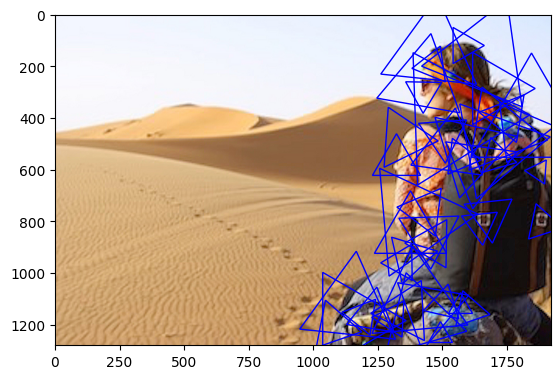

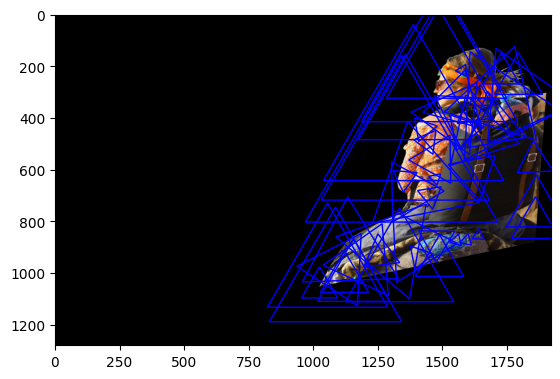

In [133]:
from skimage import data, transform,feature,color,filters
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def getInterstPoint(image):
    f = feature.corner_harris(color.rgb2gray(image[:,:,:3]), method='k', k=0.02, eps=1e-06, sigma=3)
    t = feature.corner_peaks(f, min_distance=30, threshold_rel=0.02, exclude_border=True,num_peaks=50)
    return np.stack((t[:,1],t[:,0]),axis=1)

def getFindAngle(image,point):
    im = color.rgb2gray(image)
    window = im[point[1]-10:point[1]+11,point[0]-10:point[0]+11]
    x_der = filters.sobel_v(window)
    y_der = filters.sobel_h(window)
    magnitude = np.sqrt(x_der**2 + y_der**2)
    angle = (np.arctan2(y_der,x_der)*180/np.pi).astype(int)
    uni,co = np.unique(angle,return_counts=True)
    t = (uni[np.argmax(co)])
    return t, (np.var(window)*100).astype(int)


def matchPoints(im1,im2):
    NN = 5
    for i in range(2):
        h,w = im1[::2**i,::2**i].shape[:2]
        p1 = getInterstPoint(im1[::2**i,::2**i])
        p2 = getInterstPoint(im2[::2**i,::2**i])
        gg1 = im1[::2**i,::2**i]
        gg2 = im2[::2**i,::2**i]
        plt.imshow(np.concatenate((gg1,gg2),axis=1),cmap='gray')
        plt.show()
        pairs = []
        for a in p1:
            best = np.inf
            bestVal = a
            for b in p2:
                wa = gg1[a[1]-NN:a[1]+NN+1,a[0]-NN:a[0]+NN+1].reshape(1,(2*NN+1)**2*3)
                wb = gg2[b[1]-NN:b[1]+NN+1,b[0]-NN:b[0]+NN+1].reshape(1,(2*NN+1)**2*3)
                dist = np.linalg.norm(wa-wb)
                if dist < best:
                    best = dist
                    bestVal = b
            print(best)
            if best < 2:
                p2 = p2[p2[:,0] != bestVal[0]]
                pairs += [(a,bestVal)]
        plt.imshow(np.concatenate((im1[::2**i,::2**i],im2[::2**i,::2**i]),axis=1),cmap='gray')
        plt.scatter(p1[:,0],p1[:,1],c='r',marker='x')
        plt.scatter(p2[:,0]+w,p2[:,1],c='r',marker='x')
        for a,b in pairs:
            plt.plot([a[0],b[0]+w],[a[1],b[1]])
        plt.show()
    

im2 = np.array(Image.open("./ex4/in/desert_high_res.png"))[:,:,:3]
im1 = np.array(Image.open("./ex4/in/desert_low_res.jpg"))[:,:,:3]

# matched_points = matchPoints(im1,im2)
in_ = getInterstPoint(im1)
plt.imshow(im1)
for p in in_:
    ang , var = getFindAngle(im1,p)
    plt.plot(p[0],p[1],c='#00000000',marker=(3, 0,ang), markersize=10*var,markeredgewidth=1,markeredgecolor='b')
plt.show()
in_ = getInterstPoint(im2)
plt.imshow(im2)
for p in in_:
    ang , var = getFindAngle(im2,p)
    plt.plot(p[0],p[1],c='#00000000',marker=(3, 0, ang), markersize=10*var,markeredgewidth=1,markeredgecolor='b')
plt.show()


In [134]:
def runRansac(pairs,center_point=(0,0)):
    critical = np.copy(pairs)
    critical[:,:,0] -= center_point[0]
    critical[:,:,1] -= center_point[1]
    best = np.eye(3)
    bestScore = 0
    for i in range(10000):
        sample = critical[np.random.choice(len(critical),3)]
        if np.linalg.det(sample[:,1]) == 0:
            continue
        H = sample[:,0].T @ np.linalg.inv(sample[:,1].T)
        after = transform.matrix_transform(critical[:,1,:2],H)
        dis = np.sqrt(np.sum((after - critical[:,0,:2])**2,axis=1))
        score = (np.count_nonzero(dis <= 0.5))
        # print(score,dis.astype(int))
        if score > bestScore:
            bestScore = score
            best = H
    print(bestScore)
    return best

h,w = im2.shape[:2]
matrix = runRansac(matched_points,(w/2,h/2))
print(matrix)
matrix = transform.AffineTransform(matrix=matrix)
plt.imshow(transform.warp(im2,matrix.inverse))

plt.show()


IndexError: too many indices for array: array is 0-dimensional, but 3 were indexed